In [1]:
import cv2
from scipy.signal import convolve2d
import numpy as np
import os
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.fft import dctn, idctn
import plotly.graph_objects as go
from tqdm import tqdm

In [11]:
import itertools

In [2]:
from utils.fonctions import lightDirection, lightsDirection, getI, integrationSCS, stereophotometrie


In [3]:
images = []

#path = "./data/Face_A/rti_JPG/"
path = "./data/tablette/"

file_list = os.listdir(path)
file_list.sort()

for image_path in tqdm(file_list):
    image = cv2.imread(path + image_path)
    ratio = image.shape[0] / image.shape[1]
    #image = cv2.resize(image, (1000, int(1000 * ratio)))
    images.append(image)

100%|██████████| 16/16 [00:07<00:00,  2.06it/s]


In [4]:
S = lightsDirection(images, [350, 1760, 1975, 3315])

100%|██████████| 16/16 [00:50<00:00,  3.14s/it]


In [5]:
ratio = images[0].shape[1] / images[0].shape[0]
imagesR = []
imagesG = []
imagesB = []
imagesGray = []


images2 = []
for image in images:
    i = cv2.resize(image, (1000, int(1000 * ratio)))
    imagesR.append(i[:,:,0])
    imagesG.append(i[:,:,1])
    imagesB.append(i[:,:,2])
    imagesGray.append(np.mean(i, axis=2))
    image_ref = i

In [6]:
masque = np.ones(imagesR[0].shape)
exterieur = masque.flatten() == 0
exterieur= np.reshape(exterieur, masque.shape)

I_r = getI(imagesR, corrige=True)
I_g = getI(imagesG, corrige=True)
I_b = getI(imagesB, corrige=True)
I_gray = getI(imagesGray, corrige=True)

def hex_to_rgb(hex_valeur):
    # Assurez-vous que la valeur hexadécimale commence par '#'
    if hex_valeur.startswith('#'):
        hex_valeur = hex_valeur[1:]

    # Vérification de la longueur de la chaîne hexadécimale
    if len(hex_valeur) != 6:
        raise ValueError("La valeur hexadécimale doit être de 6 caractères (sans compter '#')")

    # Extraction des composantes RVB
    rouge = int(hex_valeur[0:2], 16)
    vert = int(hex_valeur[2:4], 16)
    bleu = int(hex_valeur[4:], 16)

    return rouge, vert, bleu

In [9]:
def stereophotometrie(I,S,masque=None):
    pseudo_inverse_S = np.linalg.pinv(S)
    m = pseudo_inverse_S @ I

    rho_estime = np.sqrt(np.sum(np.square(m), 0))
    N_estime = m / (rho_estime + 1e-3)
    N_estime[:, masque.flatten() == 0] = 0

    return rho_estime, N_estime

def stereophotometrie_(I,S,m_reel,lmb=1,masque=None):
    n = S.shape[0]
    Id = np.ones((n,3))
    A = S.T @ S + lmb * Id.T @ Id
    B = lmb * m_reel.T + S.T @ I

    m = np.linalg.pinv(A) @ B

    rho_estime = np.sqrt(np.sum(np.square(m), 0))
    N_estime = m / (rho_estime + 1e-3)
    N_estime[:, masque.flatten() == 0] = 0

    return rho_estime, N_estime

def color_mediane(image, coords):
    m = []

    for coord in coords:
        x1,y1,x2,y2 = coord

        m.append([np.mean(image[y1:y2, x1:x2, 0]), np.mean(image[y1:y2, x1:x2, 1]), (np.mean(image[y1:y2, x1:x2, 2]))])

    return np.array(m) 

def metrics2(ref, test):
    return np.mean(np.abs(ref - test))

In [10]:
def stereophotometrie_base(base):
    # valeurs pour ./data/Face_A

    coords = [
        [122,89,223,188], [255,95,346,184], [385,97,476,185], [515,101,602,185], [641, 97, 730, 187], [768, 103, 855, 184],
        [128,222,213,307], [254,223,344,308], [383,222,475,306], [517,227,598,311], [643,227,729,309], [772,228,852,310],
        [125,352,213,434], [253,348,346,437], [384,350,473,437], [516,354,601,438], [640,354,730,437], [772,358,859,439],
        [122,475,215,564], [255,478,343,564], [381,478,474,565], [515,479,604,566], [643,479,727,564], [766,480,851,565],
    ] #x1,y1,x2,y2

    colors_hex = [
        "#735244", "#c29682", "#627a9d", "#576c43", "#8580b1", "#8580b1",
        "#d67e2c", "#505ba6", "#c15a63", "#5e3c6c", "#9dbc40", "#e0a32e",
        "#383d96", "#469449", "#af363c", "#e7c71f", "#bb5695", "#0885a1",
        "#f3f3f3", "#c8c8c8", "#a0a0a0", "#7a7a7a", "#555555", "#343434"
    ]


    # valeurs pour ./data/tablette

    #coords = [[3,213,73,243], [91,212,161,242], [4,252,74,281], [92,252,162,282], [5,291,74,320], [92,290,163,321], [7,330,74,359], [93,330,163,358], [6,370,74,400], [94,370,165,398], [5,410,77,437], [96,407,165,437]]
    coords = [[3,213,73,243], [91,212,161,242], [4,252,74,281], [92,252,162,282], [5,291,74,320], [92,290,163,321], [12,335,69,354], [93,330,163,358], [11,375,69,395], [94,370,165,398], [10,415,72,432], [96,407,165,437]]
    colors_hex = ["#e0a32e", "#343434", "#bb5695", "#555555", "#e7c71f", "#7a7a7a", "#af363c", "#a0a0a0", "#469449", "#c8c8c8", "#383d96", "#f3f3f3"]

    bleu_coords = coords[base[0]]
    vert_coords = coords[base[1]]
    rouge_coords = coords[base[2]]

    colors = [hex_to_rgb(i) for i in colors_hex]

    bleu_rgb = np.array(colors[base[0]])
    vert_rgb = np.array(colors[base[1]])
    rouge_rgb = np.array(colors[base[2]])


    m_reel_r = np.zeros((*masque.shape, 3))
    m_reel_g = np.zeros((*masque.shape, 3))
    m_reel_b = np.zeros((*masque.shape, 3))

    n0 = np.array([0,0,-1])

    for coord, color in zip(coords, colors):
        x1,y1,x2,y2 = coord
        r,g,b= color

        m_reel_r[y1:y2, x1:x2] = r * n0
        m_reel_g[y1:y2, x1:x2] = g * n0
        m_reel_b[y1:y2, x1:x2] = b * n0

    m_reel_r = m_reel_r.reshape(-1,3)
    m_reel_g = m_reel_g.reshape(-1,3)
    m_reel_b = m_reel_b.reshape(-1,3)


    lmb = 1

    rho_estime_r, N_estime_r = stereophotometrie_(I_r, S, m_reel_r, lmb, masque)
    rho_estime_g, N_estime_g = stereophotometrie_(I_g, S, m_reel_g, lmb, masque)
    rho_estime_b, N_estime_b = stereophotometrie_(I_b, S, m_reel_b, lmb, masque)
    rho_estime_gray, N_estime_gray = stereophotometrie(I_gray, S, masque)

    rho_estime_r = 255 * (rho_estime_r - np.min(rho_estime_r)) / (np.max(rho_estime_r) - np.min(rho_estime_r))
    rho_estime_g = 255 * (rho_estime_g - np.min(rho_estime_g)) / (np.max(rho_estime_g) - np.min(rho_estime_g))
    rho_estime_b = 255 * (rho_estime_b - np.min(rho_estime_b)) / (np.max(rho_estime_b) - np.min(rho_estime_b))

    rho_estime_r = rho_estime_r.reshape(masque.shape).astype(np.uint8)
    rho_estime_g = rho_estime_g.reshape(masque.shape).astype(np.uint8)
    rho_estime_b = rho_estime_b.reshape(masque.shape).astype(np.uint8)

    lmd_r = 1
    lmd_g = 1
    lmd_b = 1

    rho_estime_color = np.stack((lmd_b * rho_estime_b, lmd_g * rho_estime_g, lmd_r * rho_estime_r), axis=-1)

    m_color = color_mediane(rho_estime_color, coords)

    m_bleu = m_color[base[0],:]
    m_vert = m_color[base[1],:]
    m_rouge = m_color[base[2],:]

    bgr_stereo = np.stack((m_bleu, m_vert, m_rouge), axis=-1)
    bgr_stereo = bgr_stereo[::-1,:]

    bgr_original = np.stack((bleu_rgb, vert_rgb, rouge_rgb), axis=-1)
    #Inverser l'ordre des lignes pour que les couleurs soient dans le bon ordre
    bgr_original = bgr_original[::-1,:]

    det_mbgr = np.linalg.det(bgr_stereo)
    lambdas = np.zeros(rho_estime_color.shape)
    for i in range(rho_estime_color.shape[0]):
        for j in range(rho_estime_color.shape[1]):
            MB = np.stack((rho_estime_color[i,j,::-1], m_vert[::-1], m_rouge[::-1]), axis=-1)
            MG = np.stack((m_bleu[::-1], rho_estime_color[i,j,::-1], m_rouge[::-1]), axis=-1)
            MR = np.stack((m_bleu[::-1], m_vert[::-1], rho_estime_color[i,j,::-1]), axis=-1)
            lambdas[i,j,0] = np.linalg.det(MB) / det_mbgr
            lambdas[i,j,1] = np.linalg.det(MG) / det_mbgr
            lambdas[i,j,2] = np.linalg.det(MR) / det_mbgr

    rho_estime_color_corrige = np.zeros(rho_estime_color.shape)
    for i in range(rho_estime_color.shape[0]):
        for j in range(rho_estime_color.shape[1]):
            rho_estime_color_corrige[i,j,::-1] = lambdas[i,j,0]*bleu_rgb[::-1] + lambdas[i,j,1]*vert_rgb[::-1]+ lambdas[i,j,2]*rouge_rgb[::-1]

    diff = metrics2(color_mediane(rho_estime_color_corrige, coords), np.array(colors))

    return diff, base, rho_estime_color_corrige

    

In [14]:
array = list(range(0,12,2))
triplets = list(itertools.combinations(array, 3))
diffs = []
bases = []
rho_estime_color_corriges = []
for base in tqdm(triplets):
    diff, base, rho_estime_color_corrige = stereophotometrie_base(base)
    bases.append(base)
    diffs.append(diff)
    rho_estime_color_corriges.append(rho_estime_color_corrige)
    print(diff, base)

  5%|▌         | 1/20 [00:10<03:18, 10.43s/it]

42.18011928707767 (0, 2, 4)


 10%|█         | 2/20 [00:20<03:06, 10.35s/it]

77.88839018157535 (0, 2, 6)


 15%|█▌        | 3/20 [00:31<02:56, 10.36s/it]

43.18996593542579 (0, 2, 8)


 20%|██        | 4/20 [00:41<02:45, 10.36s/it]

62.31515026703423 (0, 2, 10)


 25%|██▌       | 5/20 [00:51<02:35, 10.36s/it]

47.90186768295132 (0, 4, 6)


 30%|███       | 6/20 [01:02<02:24, 10.35s/it]

72.36988727986827 (0, 4, 8)


 35%|███▌      | 7/20 [01:12<02:14, 10.36s/it]

51.224411149570734 (0, 4, 10)


 40%|████      | 8/20 [01:22<02:04, 10.36s/it]

50.271372076233725 (0, 6, 8)


 45%|████▌     | 9/20 [01:33<01:53, 10.36s/it]

66.14763874409523 (0, 6, 10)


 50%|█████     | 10/20 [01:43<01:43, 10.34s/it]

1208.4109097064772 (0, 8, 10)


 55%|█████▌    | 11/20 [01:54<01:33, 10.38s/it]

22.497353401256152 (2, 4, 6)


 60%|██████    | 12/20 [02:04<01:23, 10.43s/it]

23.137814359609152 (2, 4, 8)


 65%|██████▌   | 13/20 [02:14<01:12, 10.43s/it]

20.726693451623646 (2, 4, 10)


 70%|███████   | 14/20 [02:25<01:02, 10.42s/it]

20.81296233384595 (2, 6, 8)


 75%|███████▌  | 15/20 [02:35<00:52, 10.41s/it]

96.7632969090651 (2, 6, 10)


 80%|████████  | 16/20 [02:46<00:41, 10.40s/it]

19.72696840190899 (2, 8, 10)


 85%|████████▌ | 17/20 [02:56<00:31, 10.41s/it]

39.05955666337317 (4, 6, 8)


 90%|█████████ | 18/20 [03:06<00:20, 10.41s/it]

20.301754249376827 (4, 6, 10)


 95%|█████████▌| 19/20 [03:17<00:10, 10.40s/it]

23.855837122631947 (4, 8, 10)


100%|██████████| 20/20 [03:27<00:00, 10.39s/it]

18.252776038400768 (6, 8, 10)


(array([120.06850947, 105.5051162 , 120.27175496, 101.49578323,
         66.14763874,  45.63516776,  41.53965579, 116.49026531,
         59.36131091,  42.10861316]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

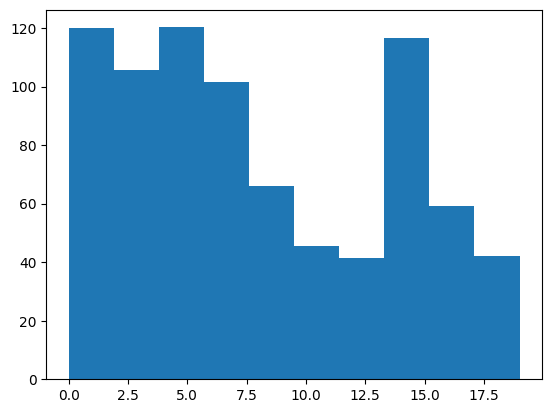

In [24]:
#Afficher un historgalmlme des différences (en log)
diffs.pop(9)
valeurs = list(range(len(triplets)))
valeurs.pop(9)
plt.hist(valeurs, weights = diffs)